### SARIMA for Time Series Forecasting

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I), and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

    A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA […] The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period.



Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

    p: Trend autoregression order.
    d: Trend difference order.
    q: Trend moving average order.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

    P: Seasonal autoregressive order.
    D: Seasonal difference order.
    Q: Seasonal moving average order.
    m: The number of time steps for a single seasonal period.

Together, the notation for a SARIMA model is specified as:
SARIMA(p,d,q)(P,D,Q)m


The SARIMA model can subsume the ARIMA, ARMA, AR, and MA models via model configuration parameters.

The trend and seasonal hyperparameters of the model can be configured by analyzing autocorrelation and partial autocorrelation plots, and this can take some expertise.

An alternative approach is to grid search a suite of model configurations and discover which configurations work best for a specific univariate time series.

    Seasonal ARIMA models can potentially have a large number of parameters and combinations of terms. Therefore, it is appropriate to try out a wide range of models when fitting to data and choose a best fitting model using an appropriate criterion …


This approach can be faster on modern computers than an analysis process and can reveal surprising findings that might not be obvious and result in lower forecast error.

### Develop a Grid Search Framework

In this section, we will develop a framework for grid searching SARIMA model hyperparameters for a given univariate time series forecasting problem.

We will use the implementation of SARIMA provided by the statsmodels library.

This model has hyperparameters that control the nature of the model performed for the series, trend and seasonality, specifically:

    order: A tuple p, d, and q parameters for the modeling of the trend.
    sesonal_order: A tuple of P, D, Q, and m parameters for the modeling the seasonality
    trend: A parameter for controlling a model of the deterministic trend as one of ‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend, respectively.

If you know enough about your problem to specify one or more of these parameters, then you should specify them. If not, you can try grid searching these parameters.

We can start-off by defining a function that will fit a model with a given configuration and make a one-step forecast.

The sarima_forecast() below implements this behavior.

The function takes an array or list of contiguous prior observations and a list of configuration parameters used to configure the model, specifically two tuples and a string for the trend order, seasonal order trend, and parameter.

We also try to make the model robust by relaxing constraints, such as that the data must be stationary and that the MA transform be invertible.

Next, we need to build up some functions for fitting and evaluating a model repeatedly via walk-forward validation, including splitting a dataset into train and test sets and evaluating one-step forecasts.

We can split a list or NumPy array of data using a slice given a specified size of the split, e.g. the number of time steps to use from the data in the test set.

The train_test_split() function below implements this for a provided dataset and a specified number of time steps to use in the test set.

After forecasts have been made for each step in the test dataset, they need to be compared to the test set in order to calculate an error score.

There are many popular error scores for time series forecasting. In this case we will use root mean squared error (RMSE), but you can change this to your preferred measure, e.g. MAPE, MAE, etc.

The measure_rmse() function below will calculate the RMSE given a list of actual (the test set) and predicted values.

We can now implement the walk-forward validation scheme. This is a standard approach to evaluating a time series forecasting model that respects the temporal ordering of observations.

First, a provided univariate time series dataset is split into train and test sets using the train_test_split() function. Then the number of observations in the test set are enumerated. For each we fit a model on all of the history and make a one step forecast. The true observation for the time step is then added to the history and the process is repeated. The sarima_forecast() function is called in order to fit a model and make a prediction. Finally, an error score is calculated by comparing all one-step forecasts to the actual test set by calling the measure_rmse() function.

The walk_forward_validation() function below implements this, taking a univariate time series, a number of time steps to use in the test set, and an array of model configuration.

If you are interested in making multi-step predictions, you can change the call to predict() in the sarima_forecast() function and also change the calculation of error in the measure_rmse() function.

We can call walk_forward_validation() repeatedly with different lists of model configurations.

One possible issue is that some combinations of model configurations may not be called for the model and will throw an exception, e.g. specifying some but not all aspects of the seasonal structure in the data.

Further, some models may also raise warnings on some data, e.g. from the linear algebra libraries called by the statsmodels library.

We can trap exceptions and ignore warnings during the grid search by wrapping all calls to walk_forward_validation() with a try-except and a block to ignore warnings. We can also add debugging support to disable these protections in the case we want to see what is really going on. Finally, if an error does occur, we can return a None result, otherwise we can print some information about the skill of each model evaluated. This is helpful when a large number of models are evaluated.

The score_model() function below implements this and returns a tuple of (key and result), where the key is a string version of the tested model configuration.

Next, we need a loop to test a list of different model configurations.

This is the main function that drives the grid search process and will call the score_model() function for each model configuration.

We can dramatically speed up the grid search process by evaluating model configurations in parallel. One way to do that is to use the Joblib library.

We can define a Parallel object with the number of cores to use and set it to the number of scores detected in your hardware

We can then can then create a list of tasks to execute in parallel, which will be one call to the score_model() function for each model configuration we have.

Finally, we can use the Parallel object to execute the list of tasks in parallel.
scores = executor(tasks)


That’s it.

We can also provide a non-parallel version of evaluating all model configurations in case we want to debug something.

The result of evaluating a list of configurations will be a list of tuples, each with a name that summarizes a specific model configuration and the error of the model evaluated with that configuration as either the RMSE or None if there was an error.

We can filter out all scores with a None.

We can then sort all tuples in the list by the score in ascending order (best are first), then return this list of scores for review.

The grid_search() function below implements this behavior given a univariate time series dataset, a list of model configurations (list of lists), and the number of time steps to use in the test set. An optional parallel argument allows the evaluation of models across all cores to be tuned on or off, and is on by default.

We’re nearly done.

The only thing left to do is to define a list of model configurations to try for a dataset.

We can define this generically. The only parameter we may want to specify is the periodicity of the seasonal component in the series, if one exists. By default, we will assume no seasonal component.

The sarima_configs() function below will create a list of model configurations to evaluate.

The configurations assume each of the AR, MA, and I components for trend and seasonality are low order, e.g. off (0) or in [1,2]. You may want to extend these ranges if you believe the order may be higher. An optional list of seasonal periods can be specified, and you could even change the function to specify other elements that you may know about your time series.

In theory, there are 1,296 possible model configurations to evaluate, but in practice, many will not be valid and will result in an error that we will trap and ignore.

We now have a framework for grid searching SARIMA model hyperparameters via one-step walk-forward validation.

It is generic and will work for any in-memory univariate time series provided as a list or NumPy array.

We can make sure all the pieces work together by testing it on a contrived 10-step datase

In [1]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
 
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models
 


Now that we have a robust framework for grid searching SARIMA model hyperparameters, let’s test it out on a suite of standard univariate time series datasets.

The datasets were chosen for demonstration purposes; I am not suggesting that a SARIMA model is the best approach for each dataset; perhaps an ETS or something else would be more appropriate in some cases

### Case Study 1: No Trend or Seasonality

The ‘daily female births’ dataset summarizes the daily total female births in California, USA in 1959.

The dataset has no obvious trend or seasonal component.

The dataset has one year, or 365 observations. We will use the first 200 for training and the remaining 165 as the test set

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
series1 = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
series1.index = pd.to_datetime(series1.index)
print(series1.shape)
series1.head()


(365, 1)


,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


C:\Users\javelascor\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


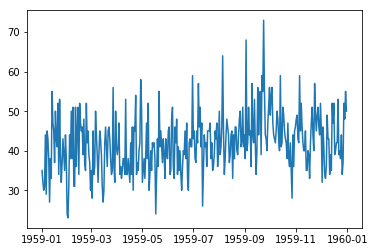

In [4]:
plt.plot(series1)
plt.savefig('timeseries.png')
plt.show()

C:\Users\javelascor\AppData\Roaming\Python\Python37\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


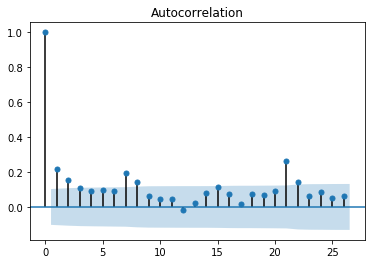

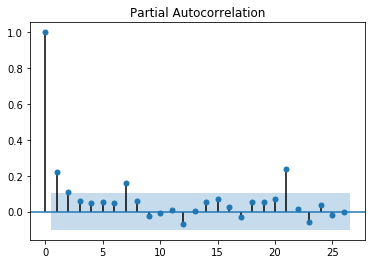

In [5]:
# plot_acf(series, lags=50)
fig = plot_acf(series1)
fig.show()
fig.savefig('acf_plot.png')

plot_pacf(series1)
plt.show()

#### Grid search

In [ ]:
data = series1.values
print(data.shape)
# data split
n_test = 165
# model configs
cfg_list = sarima_configs() # no seasonality
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(365, 1)


Running the example may take a few minutes on modern hardware.

Model configurations and the RMSE are printed as the models are evaluated The top three model configurations and their error are reported at the end of the run.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

We can see that the best result was an RMSE of about 6.77 births with the following configuration:

    Order: (1, 0, 2)
    Seasonal Order: (1, 0, 1, 0)
    Trend Parameter: ‘t’ for linear trend

It is surprising that a configuration with some seasonal elements resulted in the lowest error. I would not have guessed at this configuration and would have likely stuck with an ARIMA mode

In [ ]:
# define model configuration 
model1 = SARIMAX(series1.values,
                trend = 't',
                order = (1, 0, 2),
                seasonal_order = (1, 0, 1, 0),
                enforce_stationarity = False,
                enforce_invertibility = False)
# fit model
model1_fit = model1.fit()

#print(model2_fit.summary().tables[1])
model1_fit.plot_diagnostics(figsize=(8, 6))
plt.show()

In [ ]:
# obtain fitted valued
y_fitted = model1_fit.predict()

plt.figure()
plt.plot(series1.values)
plt.plot(y_fitted, color='r')
plt.show()

# 24 steps forecast
steps_ = 24
yhat = model1_fit.forecast(steps_)

new_dates = pd.date_range(start=series1.index[-1], periods=steps_)
prediction = pd.DataFrame({'yhat':yhat, 'time':new_dates})
prediction.set_index(['time'], inplace=True, drop=True)

plt.figure()
plt.plot(series1)
plt.plot(prediction, color='r')
plt.show()



In [ ]:
from sklearn.metrics.regression import r2_score
R2 = r2_score(series1.values, y_fitted)

## Case Study 2: Trend

The ‘shampoo’ dataset summarizes the monthly sales of shampoo over a three-year period.

The dataset contains an obvious trend but no obvious seasonal component.

(36, 1)


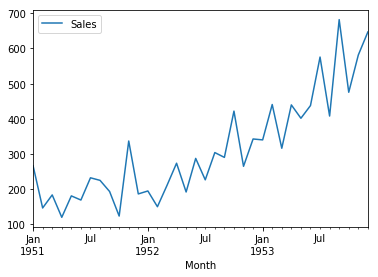

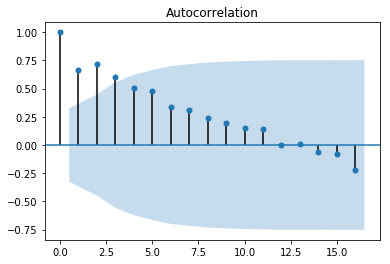

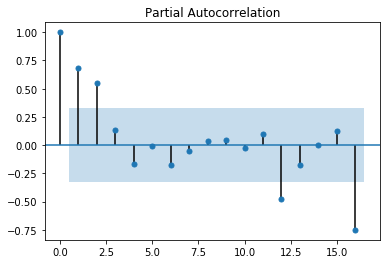

In [61]:
# parse dates
def custom_parser(x):
    return pd.datetime.strptime('195'+x, '%Y-%m')
 
# load dataset
series2 = pd.read_csv('shampoo-sales.csv', header=0, index_col=0, date_parser=custom_parser)
print(series2.shape)
series2.head()
series2.plot()
plt.show()


# plot_acf(series, lags=50)
plot_acf(series2)
plt.show()

plot_pacf(series2)
plt.show()

In [ ]:
data = series2.values
print(data.shape)
# data split
n_test = 12
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

We can see that the best result was an RMSE of about 54.76 sales with the following configuration:

    Trend Order: (0, 1, 2)
    Seasonal Order: (2, 0, 2, 0)
    Trend Parameter: ‘t’ (linear trend)

C:\Users\javelascor\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


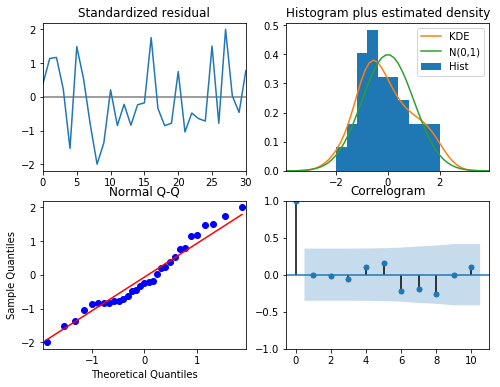

In [49]:
# define model configuration 
from statsmodels.tsa.statespace.sarimax import SARIMAX
model2 = SARIMAX(series2.values,
                trend = 't',
                order = (0, 1, 2),
                seasonal_order = (1, 0, 1, 0),
                enforce_stationarity = False,
                enforce_invertibility = False)
# fit model
model2_fit = model2.fit()

#print(model2_fit.summary().tables[1])
model2_fit.plot_diagnostics(figsize=(8, 6))
plt.show()

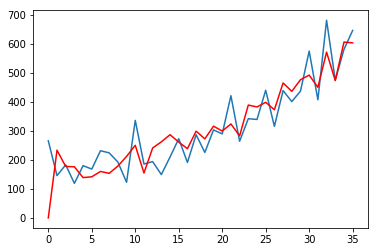

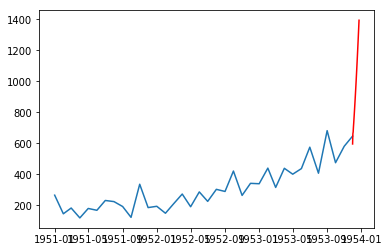

In [50]:
# obtain fitted valued
y_fitted = model2_fit.predict()

plt.figure()
plt.plot(series2.values)
plt.plot(y_fitted, color='r')
plt.show()

# 24 steps forecast
steps_ = 24
yhat = model2_fit.forecast(steps_)

new_dates = pd.date_range(start=series2.index[-1], periods=steps_)
prediction = pd.DataFrame({'yhat':yhat, 'time':new_dates})
prediction.set_index(['time'], inplace=True, drop=True)

plt.figure()
plt.plot(series2)
plt.plot(prediction, color='r')
plt.show()

## Case Study 3: Seasonality

The ‘monthly mean temperatures’ dataset summarizes the monthly average air temperatures in Nottingham Castle, England from 1920 to 1939 in degrees Fahrenheit.

The dataset has an obvious seasonal component and no obvious trend.

(240, 1)


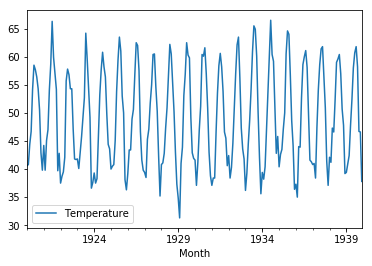

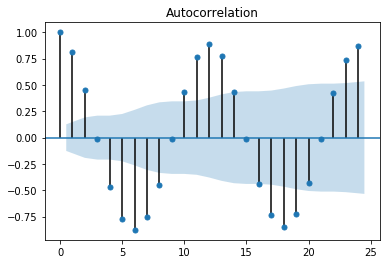

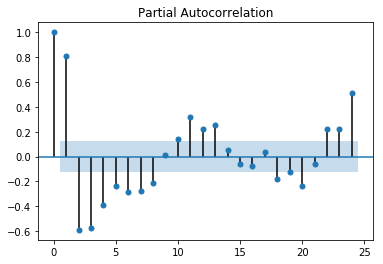

In [62]:
series3 = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=0)
series3.index = pd.to_datetime(series3.index)
print(series3.shape)
series3.head()

series3.plot()
plt.show()

# plot_acf(series, lags=50)
plot_acf(series3)
plt.show()

plot_pacf(series3)
plt.show()

The daataset has 20 years, or 240 observations (one each month)

We will trim the dataset to the last five years of data (60 observations) in order to speed up the model evaluation process and use the last year, or 12 observations, for the test set.

In [ ]:
data = series3.values
# trim dataset to 5 years
data = data[-(5*12):]
# data split
n_test = 12
# model configs
cfg_list = sarima_configs(seasonal=[0, 12])
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

We can see that the best result was an RMSE of about 1.5 degrees with the following configuration:

    Trend Order: (0, 0, 0)
    Seasonal Order: (1, 0, 1, 12)
    Trend Parameter: ‘n’ (no trend)

As we would expect, the model has no trend component and a 12-month seasonal ARMA component.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       1.0013      0.001   1556.703      0.000       1.000       1.003
ma.S.L12      -0.9191      0.087    -10.557      0.000      -1.090      -0.748
sigma2         5.5463      0.562      9.865      0.000       4.444       6.648


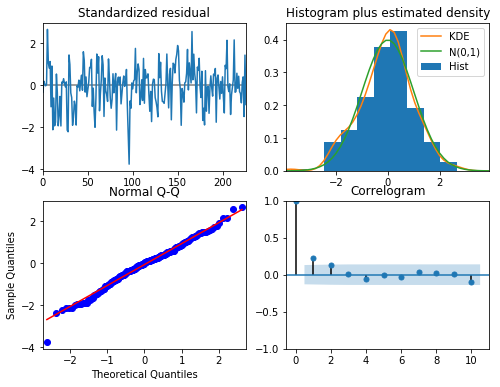

In [33]:
# define model configuration 
from statsmodels.tsa.statespace.sarimax import SARIMAX
model3 = SARIMAX(series3.values,
                trend = 'n',
                order = (0, 0, 0),
                seasonal_order = (1, 0, 1, 12),
                enforce_stationarity = False,
                enforce_invertibility = False)
# fit model
model3_fit = model3.fit()

print(model3_fit.summary().tables[1])
model3_fit.plot_diagnostics(figsize=(8, 6))
plt.show()

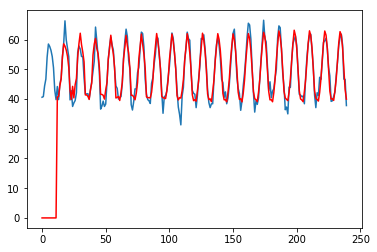

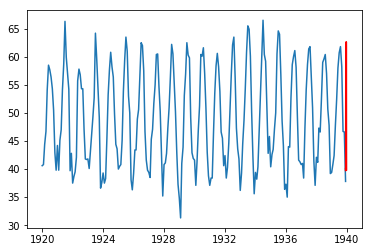

In [37]:
# obtain fitted valued
y_fitted = model3_fit.predict()

plt.figure()
plt.plot(series3.values)
plt.plot(y_fitted, color='r')
plt.show()

# 24 steps forecast
steps_ = 24
yhat = model3_fit.forecast(steps_)

new_dates = pd.date_range(start=series3.index[-1], periods=steps_)
prediction = pd.DataFrame({'yhat':yhat, 'time':new_dates})
prediction.set_index(['time'], inplace=True, drop=True)

plt.figure()
plt.plot(series3)
plt.plot(prediction, color='r')
plt.show()

## Case Study 4: Trend and Seasonality

The ‘monthly car sales’ dataset summarizes the monthly car sales in Quebec, Canada between 1960 and 1968.

The dataset has an obvious trend and seasonal component.

(108, 1)


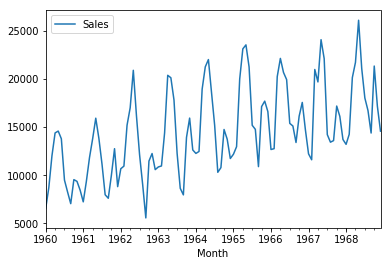

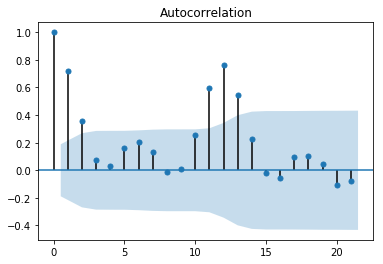

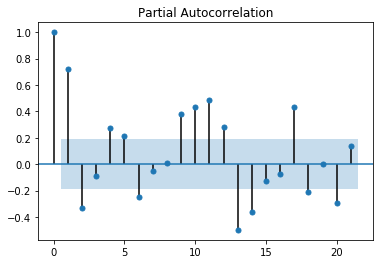

In [63]:
series4 = pd.read_csv('monthly-car-sales.csv', header=0, index_col=0)
series4.index = pd.to_datetime(series4.index)
print(series4.shape)
series4.head()
series4.plot()
plt.show()

# plot_acf(series, lags=50)
plot_acf(series4)
plt.show()

plot_pacf(series4)
plt.show()

The dataset has 9 years (108 observations, one per month). We will use the last year, or 12 observations, as the test set.

The period of the seasonal component could be 6 months or 12 months.

We will try both as the seasonal period in the call to the sarima_configs() function when preparing the model configurations

In [ ]:
data = series4.values
print(data.shape)
# data split
n_test = 12
# model configs
cfg_list = sarima_configs(seasonal=[0, 6, 12])
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(108, 1)


We can see that the best result was an RMSE of about 1,551 sales with the following configuration:

    Trend Order: (0, 0, 0)
    Seasonal Order: (1, 1, 0, 12)
    Trend Parameter: ‘t’ (linear trend)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         13.1418      2.993      4.391      0.000       7.275      19.008
ar.S.L12      -0.0311      0.079     -0.394      0.693      -0.186       0.123
sigma2      3.487e+06   5.85e+05      5.965      0.000    2.34e+06    4.63e+06


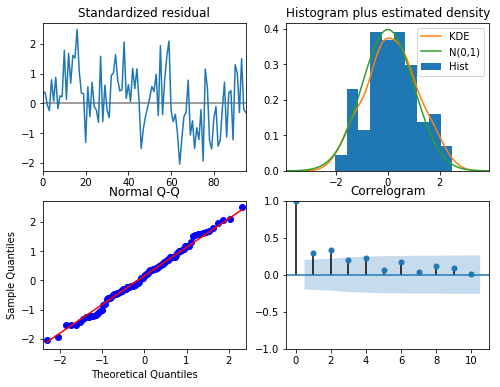

In [27]:
# define model configuration 
from statsmodels.tsa.statespace.sarimax import SARIMAX
model4 = SARIMAX(series4.values,
                trend = 't',
                order = (0, 0, 0),
                seasonal_order = (1, 1, 0, 12),
                enforce_stationarity = False,
                enforce_invertibility = False)
# fit model
model4_fit = model4.fit()

print(model4_fit.summary().tables[1])
model4_fit.plot_diagnostics(figsize=(8, 6))
plt.show()

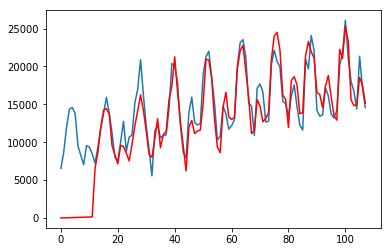

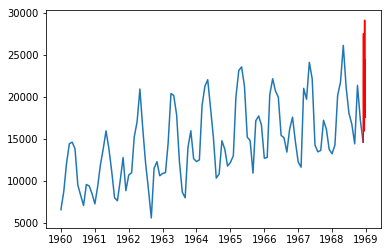

In [31]:
# obtain fitted valued
y_fitted = model4_fit.predict()

plt.figure()
plt.plot(series4.values)
plt.plot(y_fitted, color='r')
plt.show()

# 12 steps forecast
steps_ = 24
yhat = model4_fit.forecast(steps_)

new_dates = pd.date_range(start=series4.index[-1], periods=steps_)
prediction = pd.DataFrame({'yhat':yhat, 'time':new_dates})
prediction.set_index(['time'], inplace=True, drop=True)

plt.figure()
plt.plot(series4)
plt.plot(prediction, color='r')
plt.show()
